프로젝트 : 주식 예측에 도전해 보자
=======

ARIMA를 통해 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해보기

- 데이터셋 : https://finance.yahoo.com/
    
-21.11.18-

- 005930.KS.csv - 삼성전자    
- 000660.KS.csv - sk하이닉스     
- 005380.KS.csv - 현대자동차
- 036540.KQ.csv - sfa반도체   


In [1]:
!ls ~/aiffel/Exploration/E14/data

000660.KS.csv  005930.KS.csv  airline-passengers.csv
005380.KS.csv  036540.KQ.csv  daily-min-temperatures.csv


- 먼저, 005930.KS.csv 파일 데이터를 사용하겠습니다. 

# 1. 시계열 데이터 준비


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/Exploration/E14/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)    
    
    
- pd.read_csv() : parse_dates=True -> try parsing the index.    
    https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

In [3]:
ts = df['Close']

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# 2. 각종 전처리 수행

1) 결측치 처리    
2) 로그 변환

## 결측치 처리 

In [4]:
# 결측치 확인 
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

In [5]:
# 결측치가 있다면 이를 보간. 보간 기준은 time을 선택
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

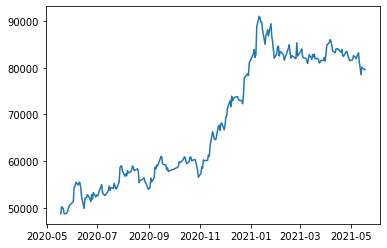

In [6]:
plt.plot(ts)

## 로그 변환 

In [7]:
# 로그 변환 시도 
ts_log = np.log(ts)

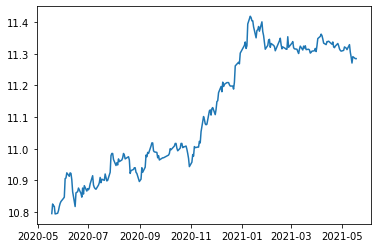

In [8]:
plt.plot(ts_log)

# 3. 시계열 안정성 분석

1) 정성적 그래프 분석     
2) 정량적 Augmented Dicky-Fuller Test     
3) 시계열 분해(Time Series Decomposition)     
4) Residual 안정성 확인

## 정성적 그래프 분석

시각화를 통해 안정성(Stationarity) 여부를 확인해 보겠습니다.   
    
현재 타임스텝 부터 window에 주어진 타임스텝 이전 사이
    
1. 구간의 평균(rolling mean, 이동평균)과
2. 표준편차(rolling std, 이동표준편차)를
    
원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있습니다.

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

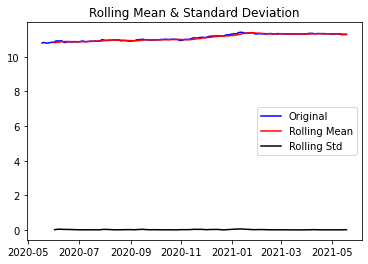

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

## 정량적 Augmented Dicky-Fuller Test

statsmodels 패키지에서 제공하는 adfuller 메소드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행합니다.
    
이 테스트는
   
- 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후,
- 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 (p-value가 거의 0에 가깝게 나타날 때)
- 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 내용입니다.

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

- statsmodels.tsa.stattools.adfuller()      
    autolag='AIC' : he number of lags is chosen to minimize the corresponding information criterion.     
    https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
    
    retrun : 
    - [0] adf : The test statistic.
    - [1] pvalue: MacKinnon’s approximate p-value based on MacKinnon (1994, 2010).
    - [2] usedlag : The number of lags used.
    - [3] nobsint : The number of observations used for the ADF regression and calculation of the critical values.
    - [4] critical values : Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

In [12]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


## 시계열 분해(Time Series Decomposition)

statsmodels 라이브러리 안에 seasonal_decompose 메소드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능을 사용합니다. 이 기능을 활용하면 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됩니다.

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

def ts_decomposition(timeseries): 
    decomposition = seasonal_decompose(timeseries, model='multiplicative', period = 30)

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화)
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return decomposition 

- statsmodels.tsa.seasonal.seasonal_decompose()    
    model='multiplicative' : Type of seasonal component     
    period=30 : Period of the series. Overrides default periodicity of x if x is a pandas object with a timeseries index.     
    https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
         
    return : 
    - A object with seasonal, trend, and resid attributes.

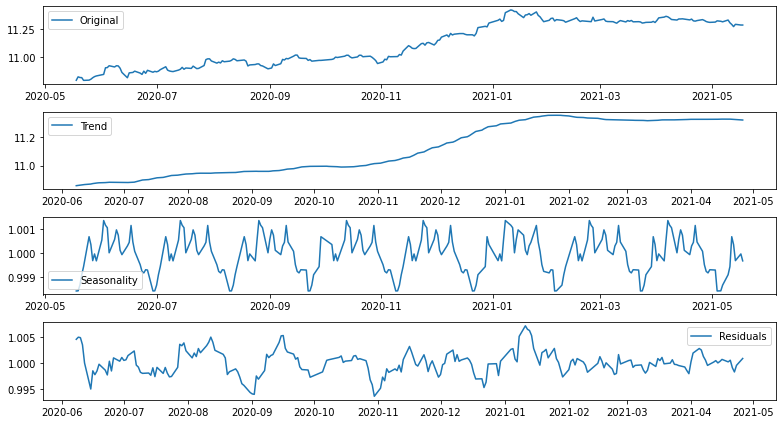

In [14]:
# 시계열 분해 (Time Series Decomposition)
decomposition = ts_decomposition(ts_log)

## Residual 안정성 확인

Residual : Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

In [15]:
residual = decomposition.resid

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다.     
    이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있습니다.

# 4. 학습, 테스트 데이터셋 생성

시계열 데이터에서 학습 데이터와 테스트 데이터를 분리합니다. 분리 비율은 학습과 테스트에 9:1로 하겠습니다. 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용합니다.

## 학습, 테스트 데이터셋 분리

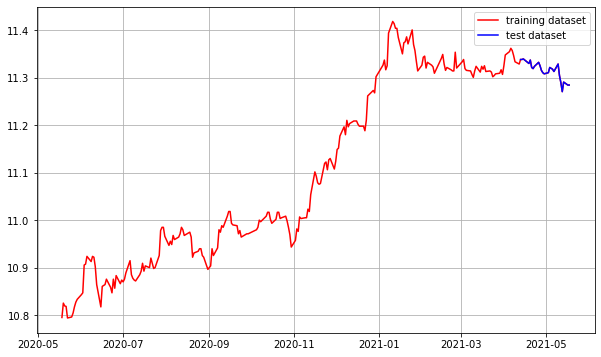

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보여 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [17]:
# 데이터셋의 형태 확인
print(train_data.shape)
print(test_data.shape)

(225,)
(25,)


# ARIMA (Autoregressive Integrated Moving Average)

## ARIMA

ARIMA 모델을 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있습니다.
- AR(자기회귀, Autoregressive) : 시계열의 Residual에 해당하는 부분을 모델링
- I(차분누적, Integration) : 시계열의 Seasonality에 해당하는 부분을 모델링
- MA(이동평균, Moving Average) : 시계열의 Trend에 해당하는 부분을 모델링

# 5. 적정 ARIMA 모수 찾기

1) ACF, PACF 그려보기 -> p,q 구하기     
2) 차분 안정성 확인 -> d 구하기
        
ARIMA의 모수는 아래의 3가지가 있습니다
- p : 자기회귀 모형(AR)의 시차
- q : 이동평균 모형(MA)의 시차
- d : 차분누적(I) 횟수
    
이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

## ACF, PACF 그려보기 -> p,q 구하기

statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용할 것입니다.     
ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있습니다. 

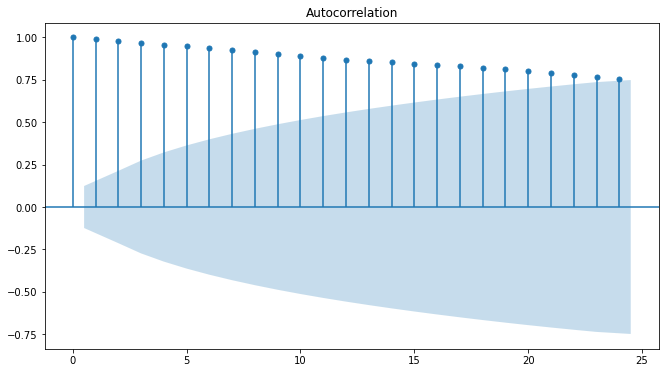

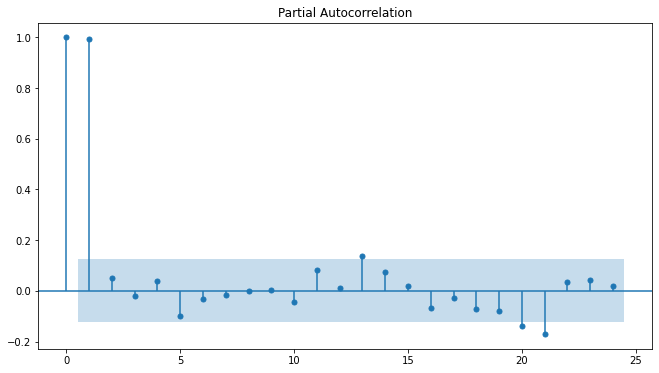

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다.      
    p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.
- 반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다.     
    MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다. 하지만 q를 바꿔 가면서 확인해 보는 것도 좋겠습니다.

## 차분 안정성 확인 -> d 구하기

d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 봅니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


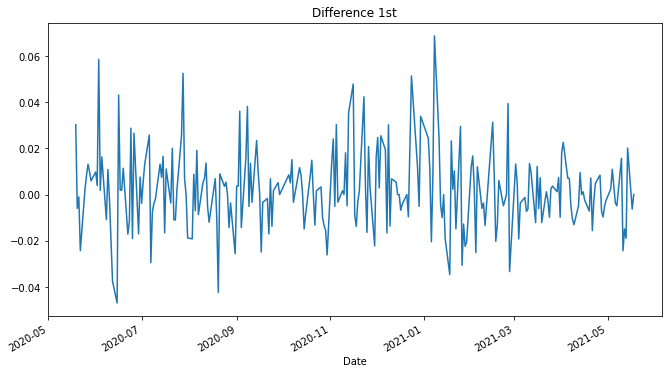

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 1차 차분을 구해보니 확실히 안정화 상태입니다. 이번 경우에는 d=1이 적합하겠습니다.

# 6. ARIMA 모델 훈련과 테스트

1) ARIMA 모델 빌드와 훈련     
2) 모델 테스트 및 플로팅      
3) 최종 예측 모델 정확도 측정(MAPE)

## ARIMA 모델 빌드와 훈련

앞에서 우리는 p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 사용하기로 하였습니다. 

In [20]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1) 

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1164.792
Time:                        12:14:18   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

- statsmodels.tsa.arima.model.ARIMA()     
    order=(1, 1, 0) : (p,d,q) order of the model for the autoregressive, differences, and moving average components     
    https://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARIMA.html
        
        
- model.fit(disp=-1) : disp < 0 means no output in this case
    https://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARIMA.fit.html

## 모델 테스트 및 플로팅

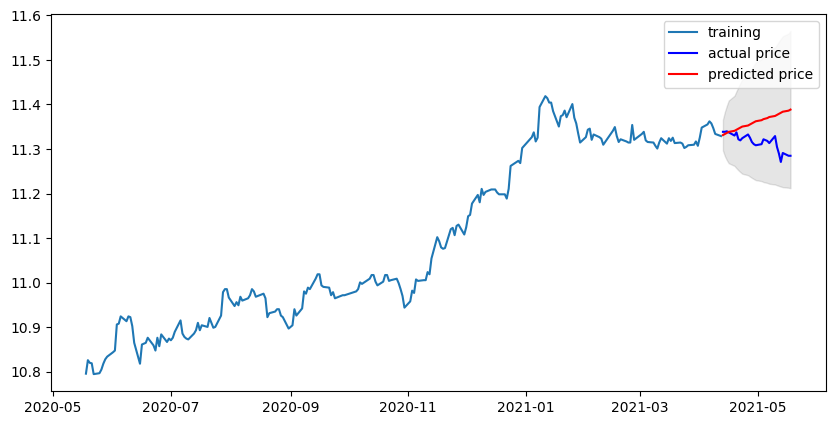

In [21]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

- statsmodels.tsa.arima_model.ARMAResults.forecast()
     https://www.statsmodels.org/v0.11.1/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html
     
    Returns
    - forecastndarray : Array of out of sample forecasts
    - stderrndarray : Array of the standard error of the forecasts.
    - conf_intndarray : 2d array of the confidence interval for the forecast

## 최종 예측 모델 정확도 측정(MAPE)

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있습니다. np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산합니다.

- MSE(Mean Squared Error)
- MAE(Mean Absolute Error)
- RMSE(Root Mean Squared error)
- MAPE(Mean Absolute Percentage Error)

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


- 최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 4.7% 정도의 오차율을 보입니다.

# 7.  다른 주식 종목 예측해 보기

1) 000660.KS.csv - sk하이닉스    
2) 005380.KS.csv - 현대자동차    
3) 036540.KQ.csv - sfa반도체

## 1) 000660.KS.csv - sk하이닉스